# Initial Setup

In [40]:
from google.colab import drive
drive.mount('./Drive')

Drive already mounted at ./Drive; to attempt to forcibly remount, call drive.mount("./Drive", force_remount=True).


In [41]:
!pip install nltk huggingface_hub scikit-learn

In [42]:
import nltk
from nltk.corpus import treebank
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, classification_report
from collections import defaultdict
import math
import re
import pandas as pd
from datasets import load_dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from huggingface_hub import login
try:
    login(token=' ')
    print("Authenticated with Hugging Face!")
except:
    print("Please enter your token manually:")
    login()

Authenticated with Hugging Face!


In [44]:
try:
    dataset = load_dataset("ColumbiaNLP/V-FLUTE")
    print("V-FLUTE dataset loaded successfully!")
    print(f"Splits: {list(dataset.keys())}")
    print(f"Train size: {len(dataset['train'])}")
except Exception as e:
    print(f"Error loading V-FLUTE: {e}")

V-FLUTE dataset loaded successfully!
Splits: ['train', 'validation', 'test']
Train size: 4578


In [45]:
nltk.download('treebank')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

#Task 1 -- POS Tagger Implementation

In [46]:
sentences = list(treebank.tagged_sents())
word_freq = defaultdict(int)
for sent in sentences:
    for word, _ in sent:
        word_freq[word.lower()] += 1

def normalize_word(word):
    w = word.lower()
    if word_freq[w] > 1:   # seen often enough → keep as is
        return w

    # Unknown word categories
    if word[0].isupper():
        return "<UNK-CAP>"
    if any(ch.isdigit() for ch in word):
        return "<UNK-NUM>"
    if w.endswith("ing"):
        return "<UNK-ING>"
    if w.endswith("ed"):
        return "<UNK-ED>"
    if w.endswith("s"):
        return "<UNK-S>"
    if w.endswith("ly"):
        return "<UNK-LY>"

    return "<UNK-OTHER>"

In [47]:
UNK_POSSIBLE_TAGS = {
    "<UNK-CAP>": ["NNP", "NN"],
    "<UNK-NUM>": ["CD"],
    "<UNK-ING>": ["VBG"],
    "<UNK-ED>": ["VBD", "VBN"],
    "<UNK-LY>": ["RB"],
    "<UNK-S>": ["NNS"],
    "<UNK-OTHER>": ["NN", "JJ", "VB"]
}

In [48]:
# Step 1: Collect counts
transition_counts = defaultdict(lambda: defaultdict(int))
emission_counts = defaultdict(lambda: defaultdict(int))
tag_counts = defaultdict(int)

for sent in sentences:
  prev_tag="<s>"
  tag_counts[prev_tag]+=1
  for word,tag in sent:
    norm_word = normalize_word(word)
    transition_counts[prev_tag][tag]+=1
    emission_counts[tag][norm_word]+=1
    tag_counts[tag]+=1
    prev_tag=tag
  transition_counts[prev_tag]["</s>"]+=1

In [49]:
# Step 2: Convert to probabilities (with log for stability)
def transition_prob(prev_tag, tag):
    return math.log((transition_counts[prev_tag][tag] + 1) / (tag_counts[prev_tag] + len(tag_counts)))



def emission_prob(tag, word):
    if word in emission_counts[tag]:
        return math.log((emission_counts[tag][word.lower()] + 1) / (tag_counts[tag] + len(emission_counts[tag])))

    # Handle unknown words
    unk_cat = normalize_word(word)
    if tag in UNK_POSSIBLE_TAGS.get(unk_cat, []):
        # small uniform probability for possible tags
        return math.log(1e-2)
    else:
        return math.log(1e-6)


In [50]:
# Step 3: Define the algorithm
def viterbi(sentence):
   # DP tables
    V = [{}]
    backpointer = [{}]

    # set of real tags (no start/end)
    real_tags = [tg for tg in tag_counts.keys() if tg not in ("<s>", "</s>")]

    # --- init (t = 0) ---
    w0 = sentence[0]
    for tag in real_tags:
        V[0][tag] = transition_prob("<s>", tag) + emission_prob(tag, w0)
        backpointer[0][tag] = "<s>"

    # --- recursion (t >= 1) ---
    for t in range(1, len(sentence)):
        V.append({})
        backpointer.append({})
        w = sentence[t]
        for tag in real_tags:

            max_prob, prev_best = max(
                (V[t-1][prev_tag] + transition_prob(prev_tag, tag) + emission_prob(tag, w), prev_tag)
                for prev_tag in V[t-1].keys()
            )
            V[t][tag] = max_prob
            backpointer[t][tag] = prev_best

    # --- termination ---
    last_t = len(sentence) - 1
    max_prob, best_last_tag = max(
        (V[last_t][tag] + transition_prob(tag, "</s>"), tag)
        for tag in V[last_t].keys()
    )

    # --- backtrack ---
    best_path = [best_last_tag]
    for t in range(len(sentence) - 1, 0, -1):
        best_path.insert(0, backpointer[t][best_path[0]])

    return list(zip(sentence, best_path))


In [51]:
# Example sentences
sentences = [
    ["I", "am", "happy"],
    ["She", "reads", "a", "book"],
    ["They", "will", "go", "to", "school"],
    ["I", "am", "Diganta", "and", "I", "love", "to", "write", "code", "every", "day"],
    ["Yesterday", "I", "spent", "hours", "collecting", "market", "data", "for", "my", "portfolio", "optimization", "project"],
    ["I", "enjoy", "solving", "complex", "math", "problems", "and", "learning", "new", "algorithms"],

]

for sent in sentences:
    tagged_sent = viterbi(sent)
    print(tagged_sent)


[('I', 'PRP'), ('am', 'VBP'), ('happy', 'NN')]
[('She', 'DT'), ('reads', 'NNS'), ('a', 'DT'), ('book', 'NN')]
[('They', 'PRP'), ('will', 'MD'), ('go', 'VB'), ('to', 'TO'), ('school', 'NNP')]
[('I', 'PRP'), ('am', 'VBP'), ('Diganta', 'NN'), ('and', 'CC'), ('I', 'DT'), ('love', 'NN'), ('to', 'TO'), ('write', 'VB'), ('code', 'NN'), ('every', 'DT'), ('day', 'NN')]
[('Yesterday', 'DT'), ('I', 'NN'), ('spent', 'VBD'), ('hours', 'NNS'), ('collecting', 'VBG'), ('market', 'NN'), ('data', 'NNS'), ('for', 'IN'), ('my', 'PRP$'), ('portfolio', 'NN'), ('optimization', 'NN'), ('project', '.')]
[('I', 'DT'), ('enjoy', 'NN'), ('solving', 'VBG'), ('complex', 'JJ'), ('math', 'NN'), ('problems', 'NNS'), ('and', 'CC'), ('learning', 'NNP'), ('new', 'NNP'), ('algorithms', 'NNS')]


#Task 2 -- Vanilla Figurative Language Recognizer

In [52]:
dataset = load_dataset("ColumbiaNLP/V-FLUTE")

In [55]:
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

print(f"Train: {len(train_data)} samples")
print(f"Validation: {len(val_data)} samples")
print(f"Test: {len(test_data)} samples")
print(f"Columns: {train_data.column_names}")



Train: 4578 samples
Validation: 726 samples
Test: 723 samples
Columns: ['image', 'claim', 'label', 'explanation', 'phenomenon', 'source_dataset']


In [56]:
# 3. Prepare text inputs (combine claim + explanation)
def combine_inputs(data):
    claims = data["claim"]
    explanations = data["explanation"]
    return [c + " " + e for c, e in zip(claims, explanations)]

In [57]:

X_train = combine_inputs(train_data)
y_train = train_data["phenomenon"]

X_val   = combine_inputs(val_data)
y_val   = val_data["phenomenon"]

X_test  = combine_inputs(test_data)
y_test  = test_data["phenomenon"]

In [58]:
vectorizer = TfidfVectorizer(max_features=20000)

In [59]:
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec   = vectorizer.transform(X_val)
X_test_vec  = vectorizer.transform(X_test)

Naive Bayes Validation Accuracy: 0.6157024793388429
Naive Bayes Test Accuracy: 0.6307053941908713

Naive Bayes Classification Report:
               precision    recall  f1-score   support

       humor       0.57      1.00      0.73       296
       idiom       0.00      0.00      0.00       100
    metaphor       0.72      0.66      0.69       167
     sarcasm       1.00      0.21      0.34       106
      simile       1.00      0.52      0.68        54

    accuracy                           0.63       723
   macro avg       0.66      0.48      0.49       723
weighted avg       0.62      0.63      0.56       723



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


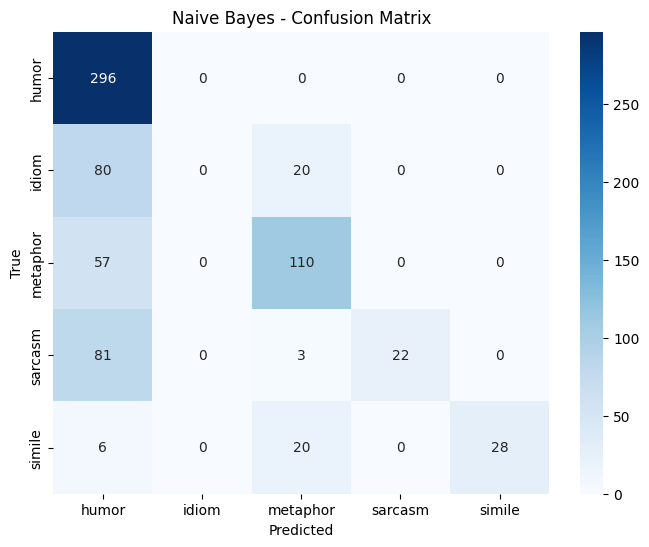


SVM Validation Accuracy: 0.940771349862259
SVM Test Accuracy: 0.9253112033195021

SVM Classification Report:
               precision    recall  f1-score   support

       humor       0.88      0.99      0.93       296
       idiom       1.00      0.85      0.92       100
    metaphor       0.94      0.92      0.93       167
     sarcasm       0.97      0.79      0.87       106
      simile       0.96      1.00      0.98        54

    accuracy                           0.93       723
   macro avg       0.95      0.91      0.93       723
weighted avg       0.93      0.93      0.92       723



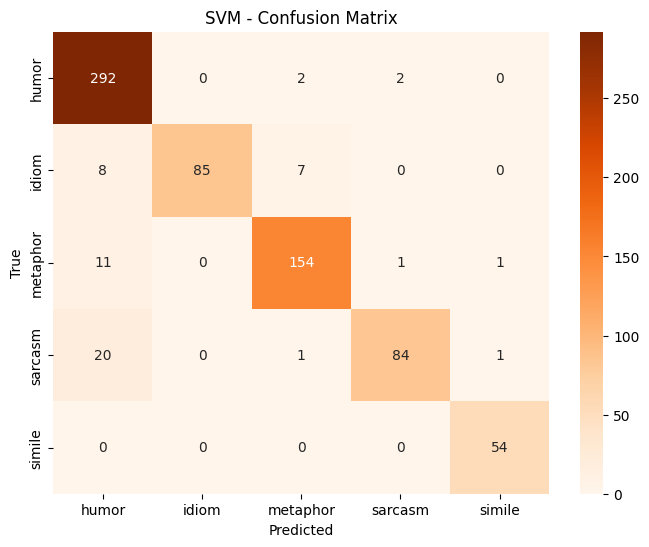

In [60]:
# ==============================
# 1. Naive Bayes
# ==============================
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

val_preds_nb = nb.predict(X_val_vec)
test_preds_nb = nb.predict(X_test_vec)

print("Naive Bayes Validation Accuracy:", accuracy_score(y_val, val_preds_nb))
print("Naive Bayes Test Accuracy:", accuracy_score(y_test, test_preds_nb))
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, test_preds_nb))

# Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, test_preds_nb, labels=nb.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues",
            xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ==============================
# 2. SVM (Linear Support Vector Classifier)
# ==============================
svm = LinearSVC()
svm.fit(X_train_vec, y_train)

val_preds_svm = svm.predict(X_val_vec)
test_preds_svm = svm.predict(X_test_vec)

print("\nSVM Validation Accuracy:", accuracy_score(y_val, val_preds_svm))
print("SVM Test Accuracy:", accuracy_score(y_test, test_preds_svm))
print("\nSVM Classification Report:\n", classification_report(y_test, test_preds_svm))


# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, test_preds_svm, labels=svm.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#Task 3 -- Improved Figurative Language Recognizer

In [61]:
class FigurativeLanguageClassifier:
  def __init__(self,max_features=10000,max_pos_features=500):
    # Vectorizer for raw texts and for POS Tag sequences
    self.text_vectorizer = TfidfVectorizer(max_features=max_features)
    self.pos_vectorizer = TfidfVectorizer(max_features=max_pos_features, ngram_range=(1,2))

    # Linear SVM classifier (chosen for strong performance on high-dimensional sparse features)
    self.classifier = LinearSVC(random_state=42, max_iter=3000)

    # Define target figurative language labels
    self.labels = ['humor', 'metaphor', 'sarcasm', 'simile', 'idiom']
    self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}
    self.idx_to_label = {idx: label for idx, label in enumerate(self.labels)}

  def extract_pos_sequences(self, texts, fit=False):
    """
    Converts input sentences into sequences of POS tags using custom Viterbi POS tagger.
    These sequences are then vectorized using TF-IDF.
    """
    pos_sequences=[]
    total=len(texts)
    print(f"POS Tagging {total} sentences...")

    for idx,text in enumerate(texts, 1):
      tokens = nltk.word_tokenize(text)
      tagged = viterbi(tokens)
      pos_tags = [tag for _, tag in tagged]
      pos_sequences.append(" ".join(pos_tags))


      if idx % 100 == 0:
          print(f"  -> Processed {idx}/{total} sentences")

    if fit:
      return self.pos_vectorizer.fit_transform(pos_sequences)
    else:
      return self.pos_vectorizer.transform(pos_sequences)

  def clean_text(self, text):
    """
    Preprocess input text by:
      - Converting to lowercase
      - Removing non-alphabetical characters
    """
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    return text

  def combine_inputs(self, claims, explanations):
    """
    Merges claim and explanation text for each sample,
    creating richer input sequences for classification.
    """
    texts = []
    for claim, explanation in zip(claims, explanations):
      texts.append(claim + " " + explanation)
    return texts

  def fit(self, claims, explanations, labels):
    """
    Training phase:
      - Combine claim + explanation text
      - Extract TF-IDF features from text
      - Extract TF-IDF features from POS sequences
      - Concatenate both feature sets
      - Train Linear SVM classifier
    """
    combine_texts = self.combine_inputs(claims, explanations)
    text_features = self.text_vectorizer.fit_transform(combine_texts)
    pos_features = self.extract_pos_sequences(combine_texts, fit=True)

    X = hstack([text_features, pos_features])
    y = [self.label_to_idx[lbl] for lbl in labels]
    print("Training classifier...")
    self.classifier.fit(X, y)
    print("Training completed.")

  def predict(self, claims, explanations):
    """
    Prediction phase:
      - Combine inputs
      - Transform using text and POS vectorizers
      - Concatenate features
      - Predict labels with trained classifier
    """
    combine_texts = self.combine_inputs(claims, explanations)
    text_features = self.text_vectorizer.transform(combine_texts)
    pos_features = self.extract_pos_sequences(combine_texts)

    X = hstack([text_features, pos_features])
    preds = self.classifier.predict(X)
    return [self.idx_to_label[pred] for pred in preds]

  def evaluate(self, claims, explanations, labels):
    """
    Evaluate model performance:
      - Generate predictions
      - Compute accuracy
      - Print classification report
      - Display confusion matrix
    """
    preds = self.predict(claims, explanations)
    acc = accuracy_score(labels, preds)
    print(f"\nOverall Accuracy: {acc}")
    print("Classification Report:")
    print(classification_report(labels, preds))

    # Confusion Matrix
    cm = confusion_matrix(labels, preds, labels=self.labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=self.labels,
                yticklabels=self.labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    return acc





In [31]:
print("Initializing enhanced classifier...")
Enhanced_clf = FigurativeLanguageClassifier(max_features=20000, max_pos_features=500)

Enhanced_clf.fit(train_data["claim"], train_data["explanation"], train_data["phenomenon"])

Initializing enhanced classifier...
POS Tagging 4578 sentences...
  -> Processed 100/4578 sentences
  -> Processed 200/4578 sentences
  -> Processed 300/4578 sentences
  -> Processed 400/4578 sentences
  -> Processed 500/4578 sentences
  -> Processed 600/4578 sentences
  -> Processed 700/4578 sentences
  -> Processed 800/4578 sentences
  -> Processed 900/4578 sentences
  -> Processed 1000/4578 sentences
  -> Processed 1100/4578 sentences
  -> Processed 1200/4578 sentences
  -> Processed 1300/4578 sentences
  -> Processed 1400/4578 sentences
  -> Processed 1500/4578 sentences
  -> Processed 1600/4578 sentences
  -> Processed 1700/4578 sentences
  -> Processed 1800/4578 sentences
  -> Processed 1900/4578 sentences
  -> Processed 2000/4578 sentences
  -> Processed 2100/4578 sentences
  -> Processed 2200/4578 sentences
  -> Processed 2300/4578 sentences
  -> Processed 2400/4578 sentences
  -> Processed 2500/4578 sentences
  -> Processed 2600/4578 sentences
  -> Processed 2700/4578 sentence


Evaluating on validation set...
POS Tagging 726 sentences...
  -> Processed 100/726 sentences
  -> Processed 200/726 sentences
  -> Processed 300/726 sentences
  -> Processed 400/726 sentences
  -> Processed 500/726 sentences
  -> Processed 600/726 sentences
  -> Processed 700/726 sentences

Overall Accuracy: 0.9504132231404959
Classification Report:
              precision    recall  f1-score   support

       humor       0.94      0.98      0.96       296
       idiom       1.00      0.83      0.91       100
    metaphor       0.94      0.98      0.96       171
     sarcasm       0.93      0.91      0.92       106
      simile       0.98      1.00      0.99        53

    accuracy                           0.95       726
   macro avg       0.96      0.94      0.95       726
weighted avg       0.95      0.95      0.95       726



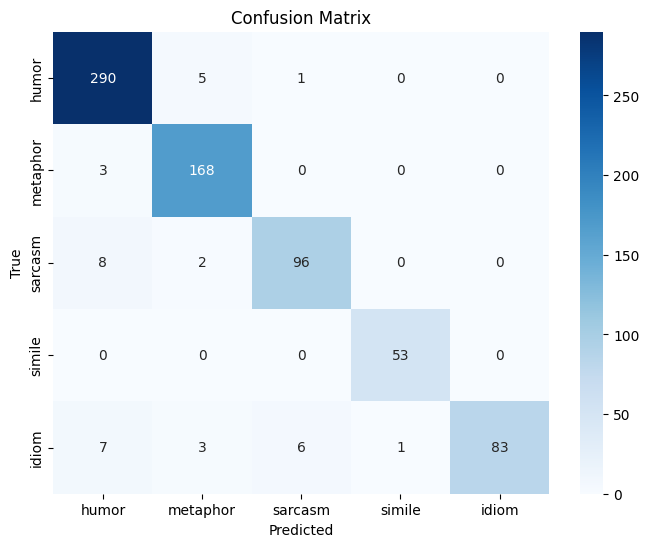

In [34]:
print("\nEvaluating on validation set...")
val_acc = Enhanced_clf.evaluate(val_data["claim"], val_data["explanation"], val_data["phenomenon"])


Evaluating on test set...
POS Tagging 723 sentences...
  -> Processed 100/723 sentences
  -> Processed 200/723 sentences
  -> Processed 300/723 sentences
  -> Processed 400/723 sentences
  -> Processed 500/723 sentences
  -> Processed 600/723 sentences
  -> Processed 700/723 sentences

Overall Accuracy: 0.9391424619640387
Classification Report:
              precision    recall  f1-score   support

       humor       0.91      0.98      0.95       296
       idiom       1.00      0.87      0.93       100
    metaphor       0.91      0.96      0.94       167
     sarcasm       0.98      0.82      0.89       106
      simile       1.00      1.00      1.00        54

    accuracy                           0.94       723
   macro avg       0.96      0.93      0.94       723
weighted avg       0.94      0.94      0.94       723



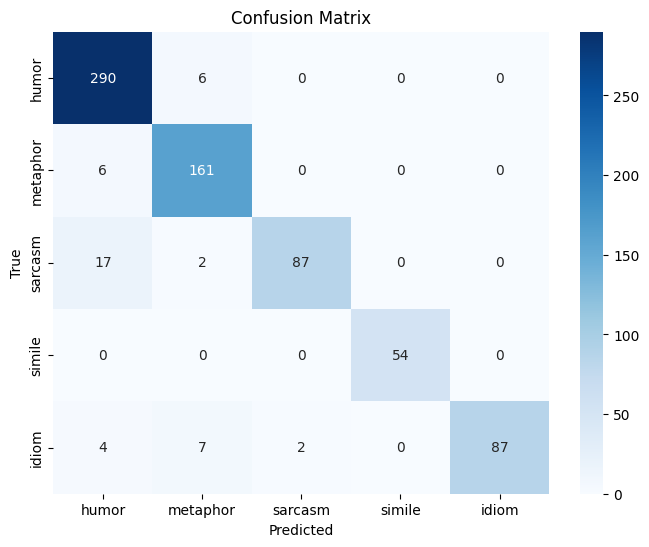

In [35]:

print("\nEvaluating on test set...")
test_acc = Enhanced_clf.evaluate(test_data["claim"], test_data["explanation"], test_data["phenomenon"])